<a href="https://colab.research.google.com/github/biglool/Hologram_Cell_detection/blob/main/notebooks/quantization/quantization_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantization aware training in Keras example

## Setup

In [ ]:
! pip install -q tensorflow
! pip install -q tensorflow-model-optimization


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.8 MB/s eta 0:00:00


In [ ]:
import tempfile
import os

import tensorflow as tf

from tensorflow_model_optimization.python.core.keras.compat import keras

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


## Train a model  without quantization aware training

In [ ]:

from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

@keras.saving.register_keras_serializable()
@tf.keras.utils.register_keras_serializable()
def jaccard_loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return 1 - (intersection + 1) / (union + 1)
get_custom_objects().update({"jaccard_loss": jaccard_loss})

@keras.saving.register_keras_serializable()
@tf.keras.utils.register_keras_serializable()
def tversky_loss(y_true, y_pred, alpha=0.5, beta=2):
    # Convert predictions to probabilities
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    # Calculate true positives (TP), false positives (FP), and false negatives (FN)
    tp = K.sum(y_true * y_pred, axis=-1)
    fp = K.sum((1 - y_true) * y_pred, axis=-1)
    fn = K.sum(y_true * (1 - y_pred), axis=-1)

    # Calculate the Tversky index
    tversky_index = (tp + K.epsilon()) / (tp + alpha * fp + beta * fn + K.epsilon())

    # Return the Tversky loss
    return 1 - tversky_index
get_custom_objects().update({"tversky_loss": tversky_loss})

@keras.saving.register_keras_serializable()
@tf.keras.utils.register_keras_serializable()
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1,2,3])
    iou = (intersection + smooth) / (sum_ - intersection + smooth)
    return iou
get_custom_objects().update({"iou": iou})

@keras.saving.register_keras_serializable()
@tf.keras.utils.register_keras_serializable()
def dice_coef_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Register the custom loss function
get_custom_objects().update({"dice_coef_loss": dice_coef_loss})

@keras.saving.register_keras_serializable()
@tf.keras.utils.register_keras_serializable()
def pixel_accuracy(y_true, y_pred):
    y_pred = K.round(y_pred)
    correct_pixels = K.sum(K.cast(K.equal(y_true, y_pred), K.floatx()))
    total_pixels = K.cast(K.prod(K.shape(y_true)), K.floatx())
    return (correct_pixels / total_pixels)
get_custom_objects().update({"pixel_accuracy": pixel_accuracy})

@keras.saving.register_keras_serializable()
@tf.keras.utils.register_keras_serializable()
def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(tf.round(y_pred), tf.int32)

    # True Negatives
    tn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 0)), tf.float32))

    # False Positives
    fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 1)), tf.float32))

    specificity = tn / (tn + fp + K.epsilon())
    return specificity
get_custom_objects().update({"specificity": specificity})

@keras.saving.register_keras_serializable()
@tf.keras.utils.register_keras_serializable()
def focal_loss(y_true, y_pred):
        gamma=2.,
        alpha=0.25
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

        # Clip the prediction values to prevent NaNs
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Compute cross-entropy loss
        cross_entropy = -y_true * K.log(y_pred)

        # Compute weight
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)

        # Compute Focal Loss
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)

get_custom_objects().update({"focal_loss": focal_loss})

@keras.saving.register_keras_serializable()
@tf.keras.utils.register_keras_serializable()
def combined_loss(y_true, y_pred):
    # Binary cross-entropy loss
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

    # Dice loss
    dice = 1 - (2 * tf.reduce_sum(y_true * y_pred) + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

    return bce + dice

In [ ]:
import tempfile
import os

import tensorflow as tf

from tensorflow_model_optimization.python.core.keras.compat import keras
from tensorflow.keras.applications import MobileNet


def create_mobilenet_encoder(input):
    #extra layer to simulate 3 channels ( testejar)
    x = keras.layers.Conv2D(3, (1, 1), padding='same',use_bias=False, activation='relu')(input)

    # Define the MobileNet architecture
    x = keras.layers.Conv2D(32, (3, 3), (2,2), padding='same', use_bias=False, name='conv1')(x)
    x = keras.layers.BatchNormalization(name='conv1_bn')(x)
    x = keras.layers.ReLU(6., name='conv1_relu')(x)

    def depthwise_conv_block(inputs, pointwise_conv_filters, block_id, strides=(1, 1)):
        x = keras.layers.DepthwiseConv2D((3, 3),  padding='same' if strides == (1, 1) else 'valid', strides=strides, use_bias=False, name=f'conv_dw_{block_id}')(inputs)
        x = keras.layers.BatchNormalization(name=f'conv_dw_{block_id}_bn')(x)
        x = keras.layers.ReLU(6., name=f'conv_dw_{block_id}_relu')(x)

        x = keras.layers.Conv2D(pointwise_conv_filters, (1, 1), padding='same', use_bias=False, name=f'conv_pw_{block_id}')(x)
        x = keras.layers.BatchNormalization(name=f'conv_pw_{block_id}_bn')(x)
        x = keras.layers.ReLU(6., name=f'conv_pw_{block_id}_relu')(x)

        return x

    x = depthwise_conv_block(x, 64, block_id=1)
    x = keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='conv_pad_2')(x)
    x = depthwise_conv_block(x, 128, block_id=2, strides=(2, 2))

    x = depthwise_conv_block(x, 128, block_id=3)
    x = keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='conv_pad_4')(x)
    x = depthwise_conv_block(x, 256, block_id=4, strides=(2, 2))

    x = depthwise_conv_block(x, 256, block_id=5)
    x = keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='conv_pad_6')(x)
    x = depthwise_conv_block(x, 512, block_id=6, strides=(2, 2))

    for i in range(7, 12):
        x = depthwise_conv_block(x, 512, block_id=i)

    x = keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='conv_pad_12')(x)
    x = depthwise_conv_block(x, 1024, block_id=12, strides=(2, 2))

    x = depthwise_conv_block(x, 1024, block_id=13)

    return x


def create_decoder(encoder_output, transpose=True, dropout=0.1):

    # Define the decoder blocks
    def create_decoder_block(input,filters, transpose=True, dropout=0.1, name=""):

        if transpose:
            x = keras.layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same', name=name+"_trans")(input)
        else:
            x = keras.layers.UpSampling2D((2, 2), interpolation="bilinear")(input)

        x = keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu',name=name)(x)
        x = keras.layers.Dropout(dropout)(x)  # adjust dropout as needed
        return x

    # Define the decoder architecture
    x=create_decoder_block(encoder_output,512, transpose=transpose, dropout=dropout)

    x=create_decoder_block(x ,256 ,transpose=transpose, dropout=dropout, name='dec_conv_1')
    x=create_decoder_block(x ,128 ,transpose=transpose, dropout=dropout, name='dec_conv_2')
    x=create_decoder_block(x ,64 , transpose=transpose, dropout=dropout, name='dec_conv_3')
    x=create_decoder_block(x ,32 , transpose=transpose, dropout=dropout, name='dec_conv_4')

    return x

# Create the model
def build_model(input_shape, load_weights=True):

  input_shape=(input_shape[0], input_shape[1], 1)
  inputs = keras.layers.Input(input_shape)

  encoder = create_mobilenet_encoder(inputs)
  decoder = create_decoder(encoder, transpose=False)
  outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder)

  model = keras.models.Model(inputs, outputs)

  if load_weights:
    # Load the pre-trained MobileNet model from Keras applications with include_top=False
    base_fold= '/content/gdrive/MyDrive/Curro/Hologrames/Datos_sinteticos/Holo_subdiv/Net_325_256_prof_950_830_siz_8_18/'
    pretrained_mobilenet = keras.models.load_model(base_fold+"Mobilenet_Upsampling_No_lambda_384_full.keras",safe_mode=False)
    #MobileNet(include_top=False, weights='imagenet', input_shape=(256, 384, 3))
    for layer in model.layers:
      if layer.name in [l.name for l in pretrained_mobilenet.layers]:
          #print(f"Copying weights from {layer.name} to {model.get_layer(name=layer.name).name}")
          layer.set_weights(pretrained_mobilenet.get_layer(name=layer.name).get_weights())


  return model

input_shape= (256, 384)
model =build_model(input_shape,load_weights=True)
model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss=jaccard_loss,#dice_coef_loss,#"binary_crossentropy",#1e-4,, , adamW,weight_decay=0.01
    metrics=[
    jaccard_loss,
    tf.keras.metrics.Recall() ,
    specificity,
    tf.keras.metrics.Precision(),
    pixel_accuracy,
    dice_coef_loss,
    tf.keras.metrics.BinaryIoU( target_class_ids=(0, 1), threshold=0.5, name=None, dtype=None),
    iou,
    focal_loss

]
)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 384, 1)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 256, 384, 3)       3         
                                                                 
 conv1 (Conv2D)              (None, 128, 192, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 128, 192, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 128, 192, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 128, 192, 32)      288       
 )                                                        

## Clone and fine-tune pre-trained model with quantization aware training


### Define the model

In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss=jaccard_loss,#dice_coef_loss,#"binary_crossentropy",#1e-4,, , adamW,weight_decay=0.01
    metrics=[
    jaccard_loss,
    tf.keras.metrics.Recall() ,
    specificity,
    tf.keras.metrics.Precision(),
    pixel_accuracy,
    dice_coef_loss,
    tf.keras.metrics.BinaryIoU( target_class_ids=(0, 1), threshold=0.5, name=None, dtype=None),
    iou,
    focal_loss

]
)

q_aware_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 384, 1)]     0         
                                                                 
 quantize_layer_7 (Quantize  (None, 256, 384, 1)       3         
 Layer)                                                          
                                                                 
 quant_conv2d_21 (QuantizeW  (None, 256, 384, 3)       12        
 rapperV2)                                                       
                                                                 
 quant_conv1 (QuantizeWrapp  (None, 128, 192, 32)      929       
 erV2)                                                           
                                                                 
 quant_conv1_bn (QuantizeWr  (None, 128, 192, 32)      129       
 apperV2)                                                 

### Train and evaluate the model against baseline

In [ ]:

import zipfile

holo_zip = '/content/gdrive/MyDrive/Curro/Hologrames/Datos_sinteticos/Holo_subdiv/Net_325_256_prof_950_830_siz_8_18.zip'

destino= "Datos_sinteticos/"

def unzip(origin,destino):
  with zipfile.ZipFile(origin, 'r') as zip_ref:
      zip_ref.extractall(destino)
unzip(holo_zip,destino)

In [ ]:
%cd 'Datos_sinteticos/'

/content/Datos_sinteticos


In [ ]:


from keras.utils import Sequence

import os

#import keras
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tq

from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


class DataGenerator(Sequence):
    def __init__(self, data_folder, ground_truth_folder, batch_size, img_shape, shuffle=True, data_augmentation=False,max_examples=0):
        self.data_folder = data_folder
        self.ground_truth_folder = ground_truth_folder
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.shuffle = shuffle
        self.data_files = sorted([f for f in os.listdir(data_folder) ])
        self.ground_truth_files = sorted([f for f in os.listdir(ground_truth_folder) ])
        self.indexes = np.arange(len(self.data_files))
        self.max_examples=max_examples
        self.on_epoch_end()
        self.rng =  tf.random.Generator.from_seed(123, alg='philox')
        self.data_augmentation = data_augmentation

    def __len__(self):
        # Number of batches per epoch
        if  self.max_examples ==0:
          num_exemp=len(self.data_files)
        else:
          num_exemp=self.max_examples
        return int(np.floor(num_exemp / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        batch_data_files = [self.data_files[k] for k in batch_indexes]
        batch_ground_truth_files = [self.ground_truth_files[k] for k in batch_indexes]

        # Generate data
        X, y = self.__data_generation(batch_data_files, batch_ground_truth_files)

        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def scale_array(self, array):
        min_val = np.min(array)
        max_val = np.max(array)
        scaled_array = 2 * (array - min_val) / (max_val - min_val) - 1
        return scaled_array

    def convert_to_int(self, array):
        min_val = np.min(array)
        max_val = np.max(array)
        scaled_array = 255 * (array - min_val) / (max_val - min_val)
        return np.array(scaled_array).astype(np.uint8)



    def augment_data(self, data_array, mascara_array):

        #left right
        lr_coin = tf.less(tf.random.uniform((), 0., 1.), 0.5)
        data_array = tf.cond(lr_coin, lambda: tf_image.flip_left_right(data_array), lambda: data_array)
        mascara_array = tf.cond(lr_coin, lambda: tf_image.flip_left_right(mascara_array), lambda: mascara_array)

        # updown flip
        ud_coin = tf.less(tf.random.uniform((), 0., 1.), 0.5)
        data_array = tf.cond(ud_coin, lambda: tf_image.flip_up_down(data_array), lambda: data_array)
        mascara_array = tf.cond(ud_coin, lambda: tf_image.flip_up_down(mascara_array), lambda: mascara_array)

        # brightness
        bright_coin = tf.less(tf.random.uniform((), 0., 1.), 0.2)
        seed = self.rng.make_seeds(2)[0]
        data_array=tf.cond(bright_coin, lambda: np.array(tf_image.stateless_random_brightness(np.array(data_array).T, max_delta=0.95, seed=seed)).T, lambda: data_array)


        #contrast
        contrastt_coin = tf.less(tf.random.uniform((), 0., 1.), 0.2)
        seed = self.rng.make_seeds(2)[0]
        data_array=tf.cond(contrastt_coin, lambda: np.array(tf_image.stateless_random_contrast(np.array(data_array).T, lower=0.1, upper=0.9, seed=seed)).T, lambda: data_array)

        data_array = self.scale_array(data_array)

        return data_array, mascara_array



    def __data_generation(self, batch_data_files, batch_ground_truth_files):
        # Initialization
        X = np.empty((self.batch_size, *self.img_shape), dtype='uint8')#'float32')
        y = np.empty((self.batch_size, *self.img_shape), dtype='uint8')#'float32')

        # Generate data
        for i, (data_file, gt_file) in enumerate(zip(batch_data_files, batch_ground_truth_files)):
            # Load data and ground truth
            data_array = np.loadtxt(os.path.join(self.data_folder, data_file))
            data_array = self.scale_array(data_array)
            data_array =data_array.reshape(self.img_shape)

            ground_truth_array= np.loadtxt(os.path.join(self.ground_truth_folder, gt_file))
            ground_truth_array=ground_truth_array.reshape(self.img_shape)#np.expand_dims(ground_truth_array,axis=2)

            # data augmentation

            if self.data_augmentation:
               data_array, ground_truth_array =   self.augment_data(data_array,ground_truth_array)



            X[i,] = self.convert_to_int(data_array)#.reshape(self.img_shape)
            y[i,] = np.array(ground_truth_array).astype(np.uint8) #.reshape(self.img_shape)

        return X, y


# fer unzip aki per treballar en local
#zip_file="/content/gdrive/MyDrive/Curro/Hologrames/
#destino = "/content/"
#unzip(holo_zip,destino_holo)

data_folder = 'hologramas' #afegir  destino
ground_truth_folder = 'mascaras' #afegir  destino
img_shape = (256,384,1)
batch_size=16
#(2662,2128,1)


# Create data generators for training, validation, and test sets
train_gen = DataGenerator(data_folder+"/train/", ground_truth_folder+"/train/", batch_size,img_shape,data_augmentation=True, shuffle=True)
val_gen = DataGenerator(data_folder+"/val/", ground_truth_folder+"/val/", batch_size, img_shape, shuffle=False)
test_gen = DataGenerator(data_folder+"/test/", ground_truth_folder+"/test/", batch_size, img_shape, shuffle=False)

500
imagen


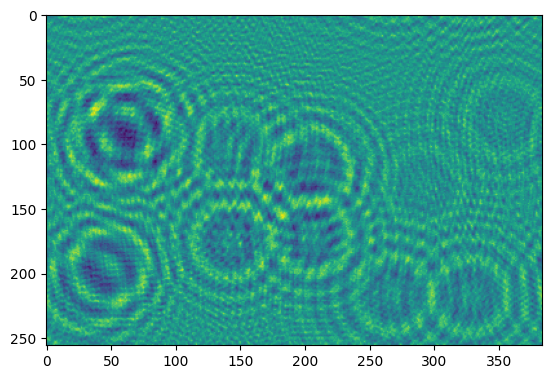

mascara


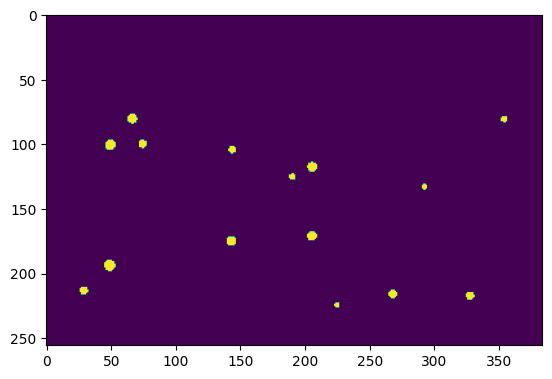

(array([0, 1], dtype=uint8), array([97763,   541]))
imagen


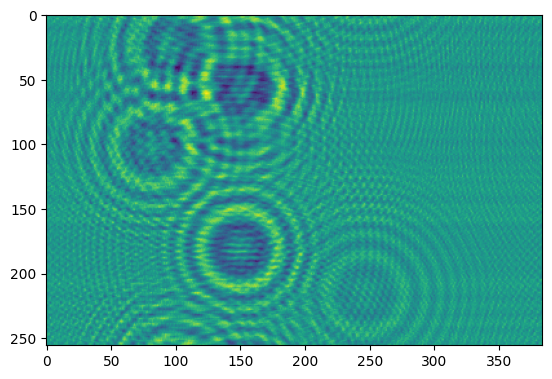

mascara


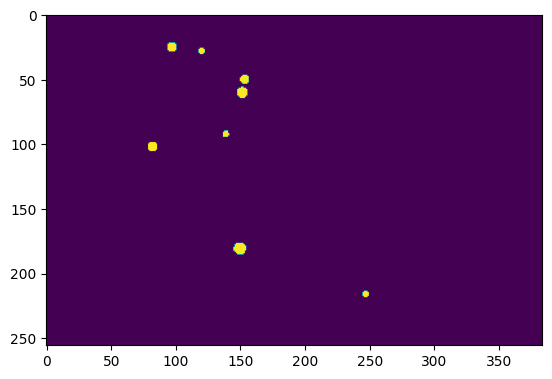

(array([0, 1], dtype=uint8), array([97979,   325]))
imagen


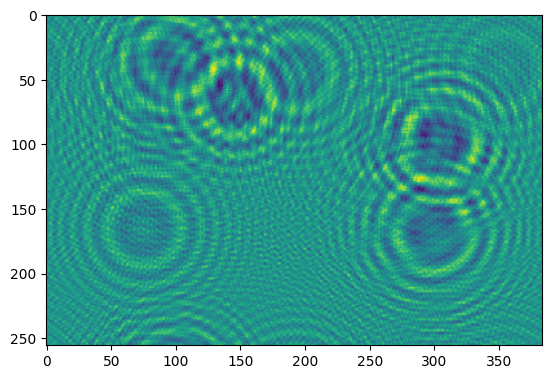

mascara


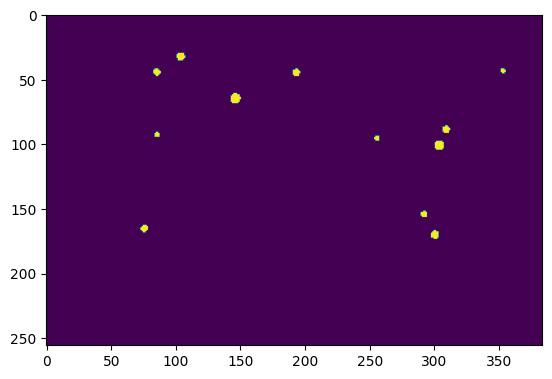

(array([0, 1], dtype=uint8), array([97970,   334]))
imagen


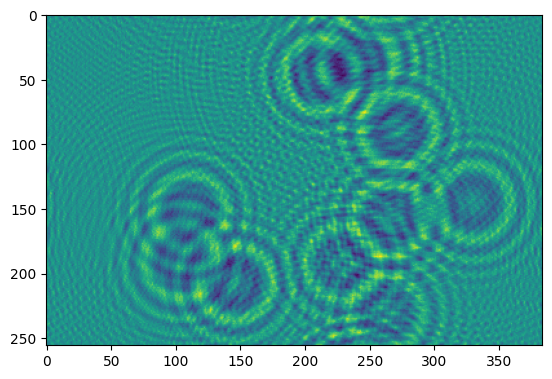

mascara


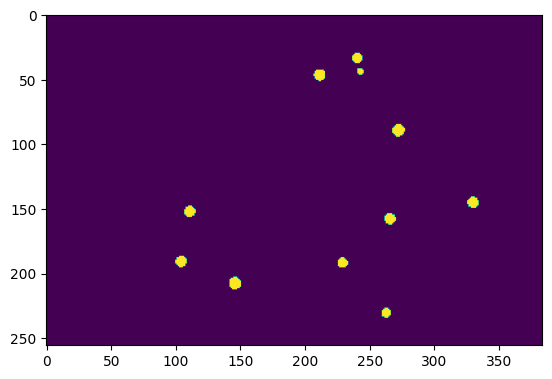

(array([0, 1], dtype=uint8), array([97675,   629]))
imagen


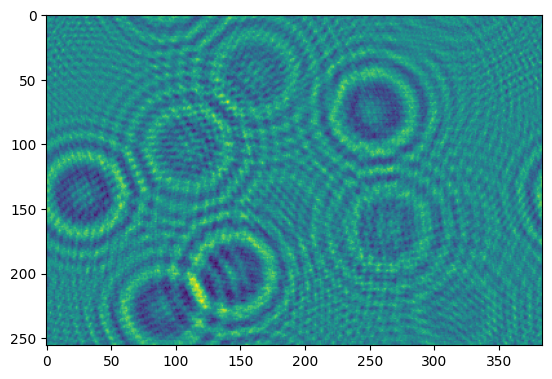

mascara


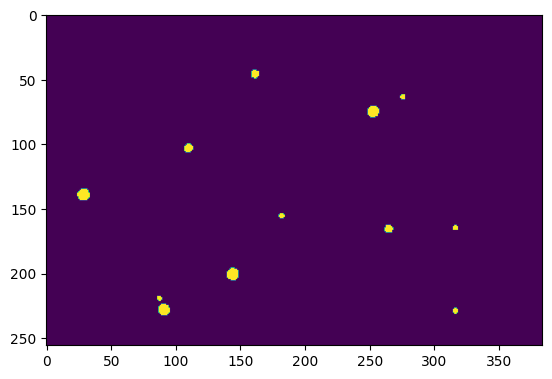

(array([0, 1], dtype=uint8), array([97844,   460]))
imagen


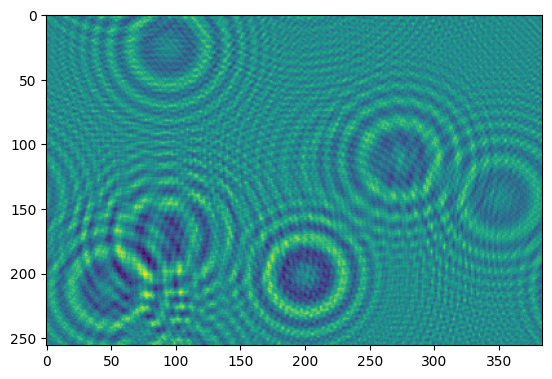

mascara


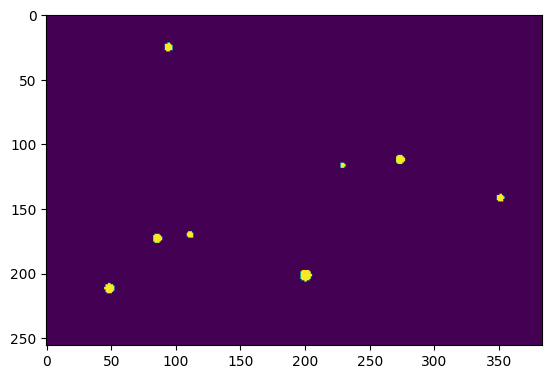

(array([0, 1], dtype=uint8), array([98012,   292]))
imagen


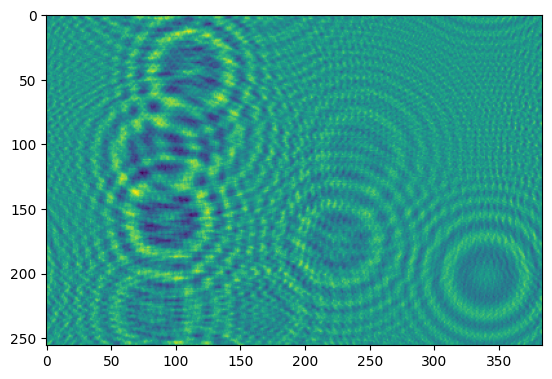

mascara


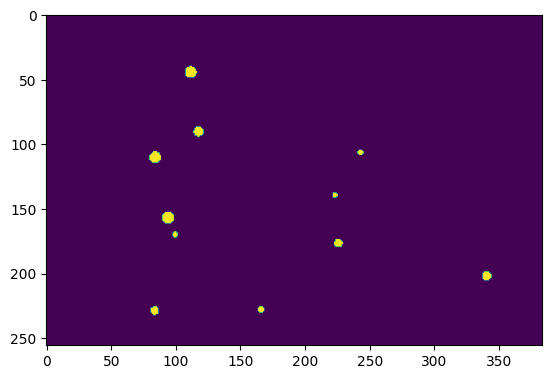

(array([0, 1], dtype=uint8), array([97883,   421]))
imagen


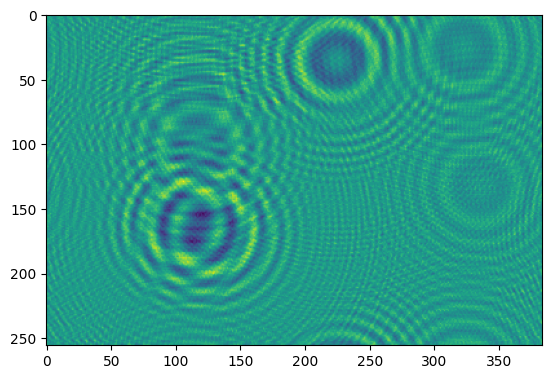

mascara


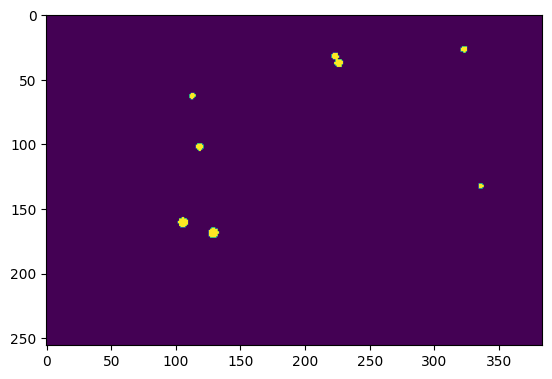

(array([0, 1], dtype=uint8), array([98064,   240]))
imagen


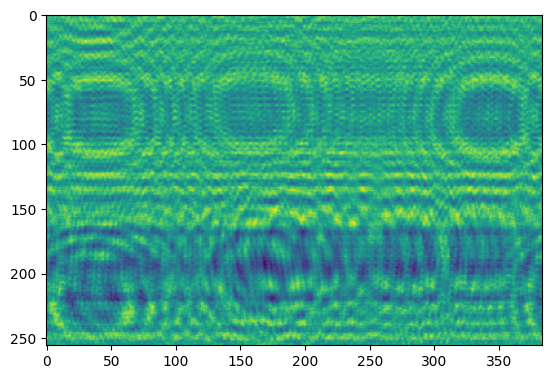

mascara


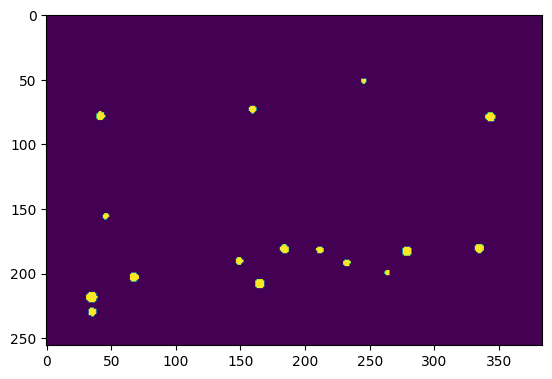

(array([0, 1], dtype=uint8), array([97766,   538]))
imagen


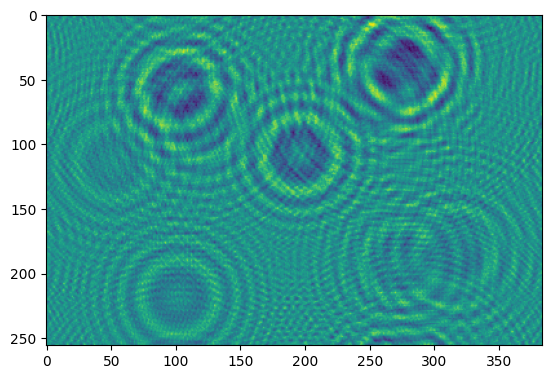

mascara


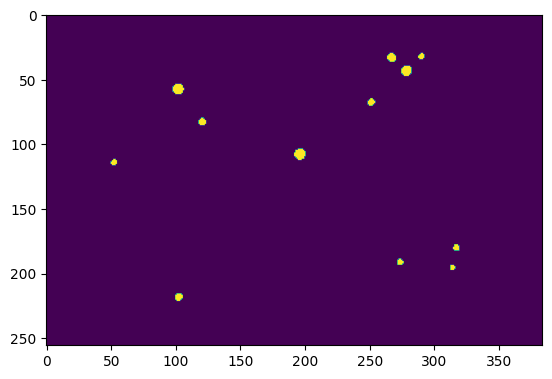

(array([0, 1], dtype=uint8), array([97914,   390]))
imagen


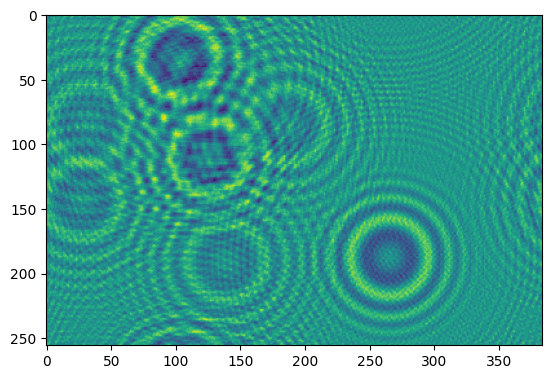

mascara


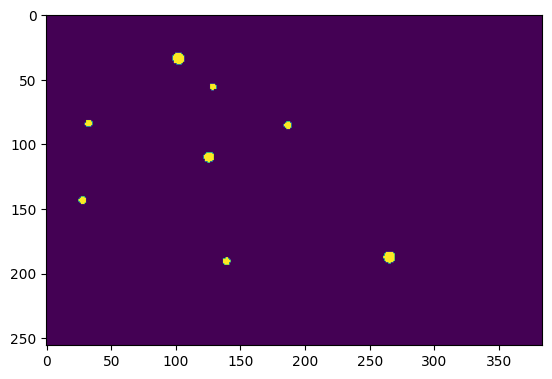

(array([0, 1], dtype=uint8), array([97992,   312]))
imagen


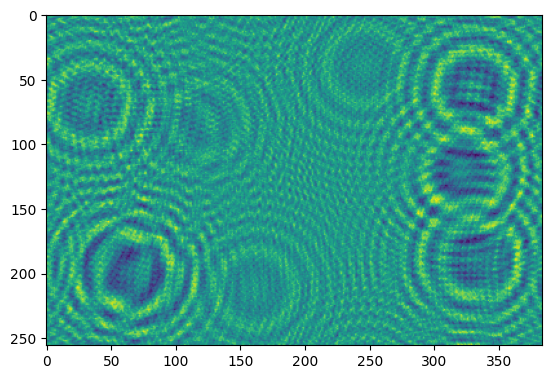

mascara


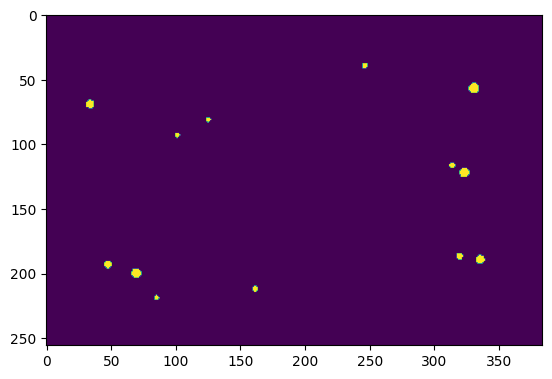

(array([0, 1], dtype=uint8), array([97963,   341]))
imagen


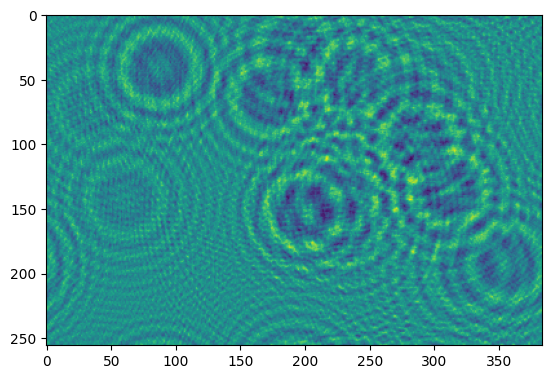

mascara


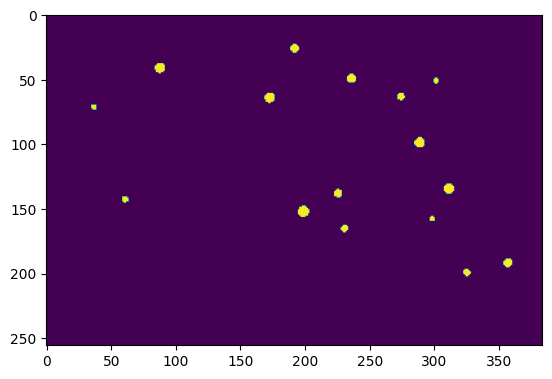

(array([0, 1], dtype=uint8), array([97740,   564]))
imagen


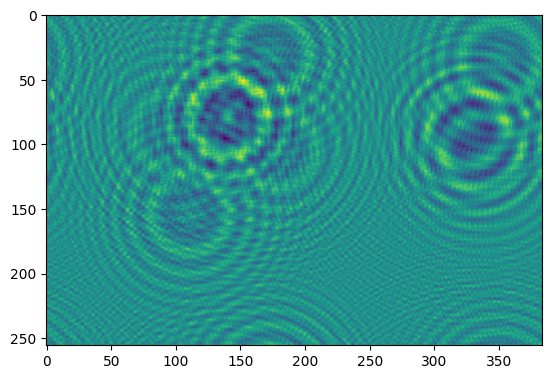

mascara


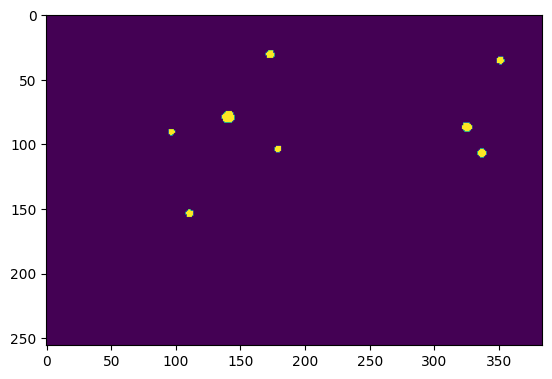

(array([0, 1], dtype=uint8), array([98017,   287]))
imagen


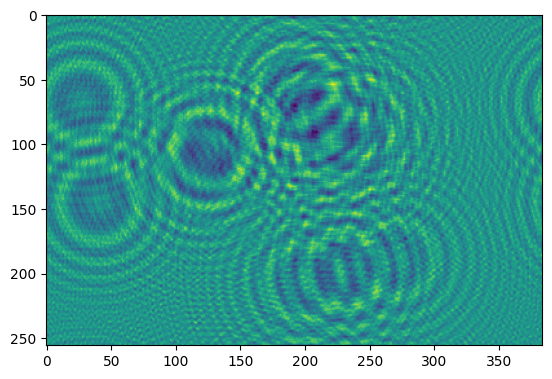

mascara


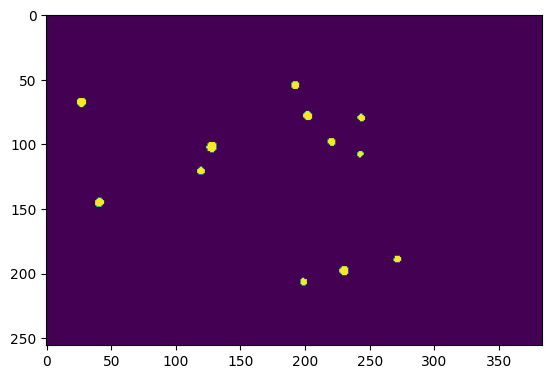

(array([0, 1], dtype=uint8), array([97908,   396]))
imagen


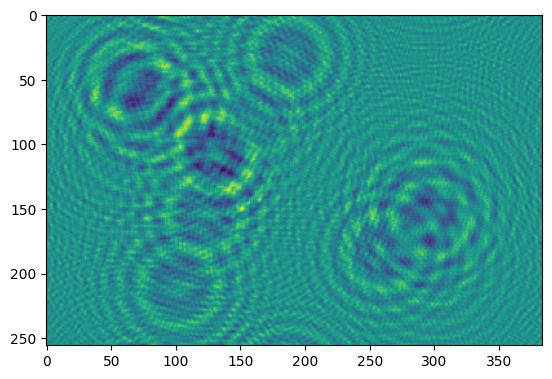

mascara


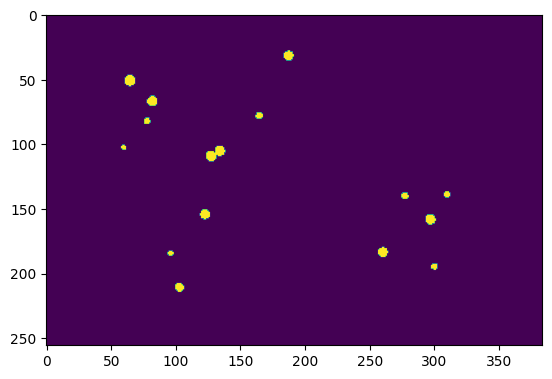

(array([0, 1], dtype=uint8), array([97714,   590]))


In [ ]:

print(train_gen.__len__())

hey=train_gen.__getitem__(0)
for x,y in zip(hey[0],hey[1]):
  print("imagen")
  plt.imshow(x)
  plt.show()
  print("mascara")
  plt.imshow(y)

  plt.show()
  print(np.unique(y,return_counts=True))


In [ ]:
epochs=1
for epoch in range(1,epochs+1):
  print(epoch)
# full training a manita
  for i in range(0,train_gen.__len__()):
    train_data=train_gen.__getitem__(i)
    train_images =train_data[0]
    train_labels=train_data[1]

    q_aware_model.fit(
      train_images,
      train_labels,
      epochs=1,
      validation_split=0.1,
    )


1
1/1 [==============================] - 1s 727ms/step - loss: 0.2648 - jaccard_loss: 0.2648 - recall_2: 0.8389 - specificity: 0.9994 - precision_2: 0.0302 - pixel_accuracy: 0.9987 - dice_coef_loss: 0.1526 - binary_io_u_2: 0.4557 - iou: 0.7455 - focal_loss: 0.6230 - val_loss: 0.2496 - val_jaccard_loss: 0.2496 - val_recall_2: 0.8389 - val_specificity: 0.9997 - val_precision_2: 0.0302 - val_pixel_accuracy: 0.9987 - val_dice_coef_loss: 0.1427 - val_binary_io_u_2: 0.4557 - val_iou: 0.7477 - val_focal_loss: 0.8338


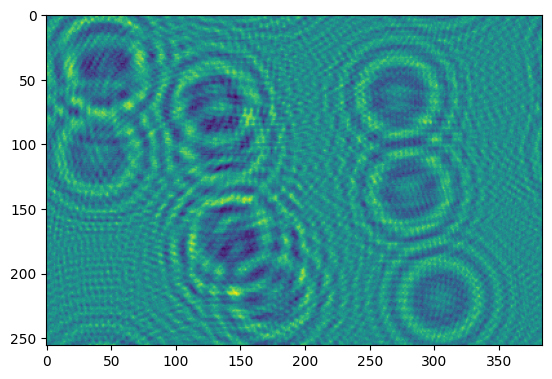

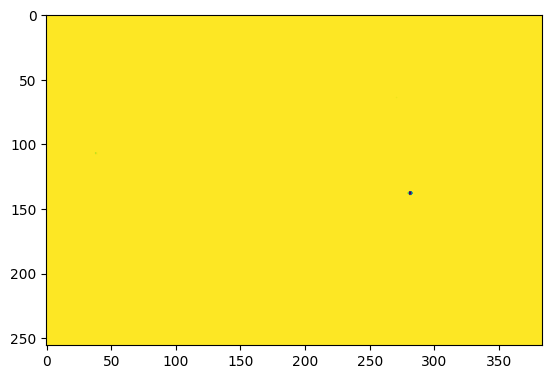

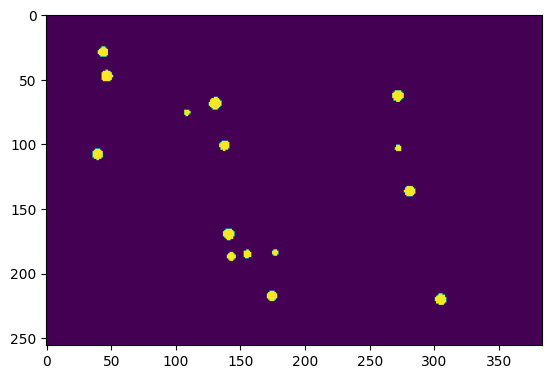

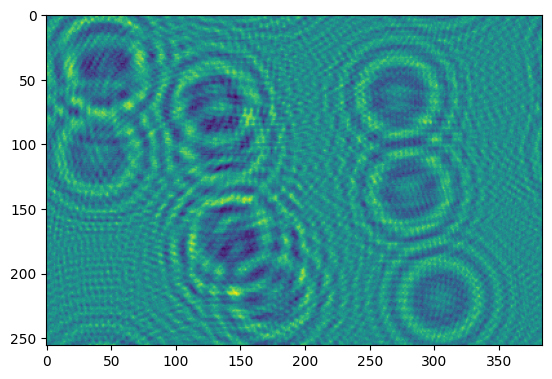

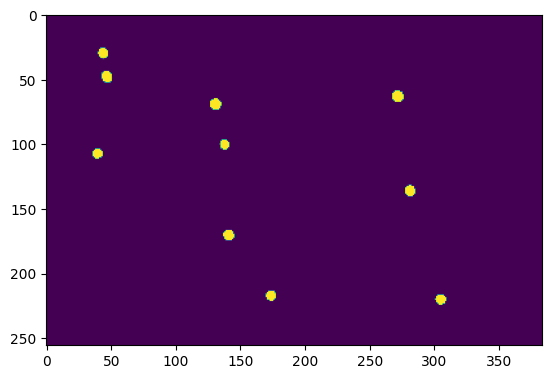

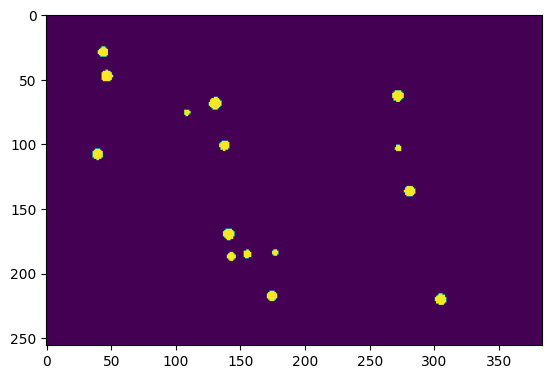

In [ ]:
test_data=test_gen.__getitem__(0)
test_images =test_data[0]
test_labels=test_data[1]

#model.evaluate( test_images, test_labels, verbose=0)
#falta preentrenar original amb dades enters!!!!
model.evaluate(test_images, test_labels, verbose=0)
preds=model.predict(test_images, verbose=0)
plt.imshow(test_images[1])
plt.show()
plt.imshow(preds[1])
plt.show()
plt.imshow(test_labels[1])
plt.show()

q_aware_model.evaluate(test_images, test_labels, verbose=0)
preds=q_aware_model.predict(test_images, verbose=0)
plt.imshow(test_images[1])
plt.show()
plt.imshow(preds[1])
plt.show()
plt.imshow(test_labels[1])
plt.show()

In [ ]:

ruta_model="quantatization_model.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ruta_model, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=17),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)
]

# Train the model, doing validation at the end of each epoch.
epochs = 200
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1,
    class_weight = {0:1,1:10}
)


ValueError: Failed to find data adapter that can handle input: <class '__main__.DataGenerator'>, <class 'NoneType'>

In [ ]:


q_aware_model.fit(train_images_subset, train_labels_subset,
                  batch_size=500, epochs=1, validation_split=0.1)

2/2 [==============================] - 4s 619ms/step - loss: 0.1566 - accuracy: 0.9556 - val_loss: 0.1865 - val_accuracy: 0.9400


For this example, there is minimal to no loss in test accuracy after quantization aware training, compared to the baseline.

In [ ]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

_, q_aware_model_accuracy = q_aware_model.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)

Baseline test accuracy: 0.960099995136261
Quant test accuracy: 0.9607999920845032


## Create quantized model for TFLite backend

After this, you have an actually quantized model with int8 weights and uint8 activations.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

## See persistence of accuracy from TF to TFLite

Define a helper function to evaluate the TF Lite model on the test dataset.

In [ ]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy

You evaluate the quantized model and see that the accuracy from TensorFlow persists to the TFLite backend.

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)
print('Quant TF test accuracy:', q_aware_model_accuracy)

## See 4x smaller model from quantization

You create a float TFLite model and then see that the quantized TFLite model
is 4x smaller.

In [ ]:
# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(quantized_tflite_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

## Conclusion

In this tutorial, you saw how to create quantization aware models with the TensorFlow Model Optimization Toolkit API and then quantized models for the TFLite backend.

You saw a 4x model size compression benefit for a model for MNIST, with minimal accuracy
difference. To see the latency benefits on mobile, try out the TFLite examples [in the TFLite app repository](https://www.tensorflow.org/lite/models).

We encourage you to try this new capability, which can be particularly important for deployment in resource-constrained environments.
